In [ ]:
# imports -----------------------------------------------------------------
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

from datetime import datetime

import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

import torch.nn as nn
import torch.optim as optim

from torchsummary import summary

In [24]:
# hyperparams -------------------------------------------------------------

# NOTE: as an attempt to streamline hyperparam study, all tunable hyper
#       params are listed below and ideally won't be hardcoded elsewhere
#
#       intended use case (but ofc do what works!): 
#         1 - name this iteration
#         2 - update the value below that is being tested in this iter 
#         3 - rerun the notebook
#         4 - model, loss curves, accuracy curves, and plots are saved

SAVE_AS_ITER = "baseline"                         # name of this iteration

EPOCHS = 20                                       # num of epochs to train
BATCH_SIZE = 32                                   # batch size
IMG_H = 175                                       # orig img size
IMG_W = 1550                                      # orig img size
IMG_RESZ = 32                                     # img resized

TRAIN_SHUFFLE = True                              # shuffle in dataloader
EVAL_SHUFFLE = True                               # shuffle in dataloader

CIN = 3                                           # RGB 3 channels in
C1 = 16                                           # start with 16 filters
C2 = 32                                           # double num of filters
COUT = 1                                          # 1 for positive channel

CONV1_K = 3                                       # kernel sz of conv1
CONV1_P = 1                                       # padding of conv1
CONV2_K = 3                                       # kernel sz of conv2
CONV2_P = 1                                       # padding of conv2
POOL1_K  = 2                                      # kernel sz of maxpool1 
POOL2_K = 2                                       # kernle sz of maxpool2

FC1 = C2*8*8                                      # size into FC1
FC2 = 64                                          # size out FC1, in FC2

LR = 0.001                                        # learning rate

In [42]:
# organize directories ----------------------------------------------------
cwd = os.getcwd()                                 
# access data here
train_dir = cwd+"/spg_data/train/"
val_dir = cwd+"/spg_data/val/"
test_dir = cwd+"/spg_data/test/"

# data for visualization
vis_dir = cwd+"/spg_data/for_testing_visualization/"

# save iterations here
date = datetime.today().strftime('%Y-%m-%d')
iter_dir = cwd+"/saved_iterations/"+date+"/"

In [26]:
# CUDA --------------------------------------------------------------------
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


In [27]:
# prep data ---------------------------------------------------------------

# NOTE:
# - already noted with group, but am concerned about data leakage based on
#   how data was organized
# - did not use random split, hopefully helps combat data leakage a little
# - it is nontrivial to split after ImageFolder application, so folders
#   should be organized into train, val, and test beforehand
# - 80/10/10 split
# - spect imgs are originally (175, 1550)

# transforms 
train_tf = transforms.Compose([
    transforms.Resize((IMG_RESZ, IMG_RESZ)),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

eval_tf = transforms.Compose([
    transforms.Resize((IMG_RESZ, IMG_RESZ)),
    transforms.ToTensor()
])

# ImageFolder
train_ds = datasets.ImageFolder(root=train_dir, transform=train_tf)
val_ds = datasets.ImageFolder(root=val_dir, transform=eval_tf)
test_ds = datasets.ImageFolder(root=test_dir, transform=eval_tf)

# DataLoader
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE,
                      shuffle=TRAIN_SHUFFLE, num_workers=2)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE,
                      shuffle=EVAL_SHUFFLE, num_workers=2)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE,
                      shuffle=EVAL_SHUFFLE, num_workers=2)

In [28]:
# CNN model ---------------------------------------------------------------
# architecture based on:
# Pizak (2015) "Environmental Sound Classification with CNNs"
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(CIN, C1, kernel_size=CONV1_K, padding=CONV1_P)
    self.relu1 = nn.ReLU(inplace=True)
    self.pool1 = nn.MaxPool2d(kernel_size=POOL1_K)
    self.dropout1 = nn.Dropout(0.5)
    self.conv2 = nn.Conv2d(C1, C2, kernel_size=CONV2_K, padding=CONV2_P)
    self.relu2 = nn.ReLU(inplace=True)
    self.pool2 = nn.MaxPool2d(kernel_size=POOL2_K)
    self.dropout2 = nn.Dropout(0.5)
    self.fc1 = nn.Linear(FC1, FC2)
    self.relu3 = nn.ReLU(inplace=True)
    self.fc2 = nn.Linear(FC2, COUT)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.relu1(self.conv1(x))
    x = self.dropout1(self.pool1(x))
    x = self.relu2(self.conv2(x))
    x = self.dropout2(self.pool2(x))
    x = x.view(-1, FC1)
    x = self.relu3(self.fc1(x))
    x = self.sigmoid(self.fc2(x))
    return x
  

def test_CNN():
  '''
  this function checks the input and output sizes of our CNN model
  '''
  # example input of single batch_size
  x = torch.zeros((BATCH_SIZE, CIN, IMG_RESZ, IMG_RESZ), 
                  dtype=torch.float32)
  model = CNN()
  y = model(x)
  print("input size to CNN:\n", np.shape(x))
  print("\noutput size from CNN:\n", np.shape(y))

test_CNN()
# in:  [batch size, num of input channels, img height, img width]
# out: [batch size, output channel (our positive class)]

# alternatively, print torchsummary summary
# model = CNN()
# summary(model, input_size=(CIN, IMG_RESZ, IMG_RESZ), 
#                            batch_size=BATCH_SIZE)

input size to CNN:
 torch.Size([32, 3, 32, 32])

output size from CNN:
 torch.Size([32, 1])


In [ ]:
# processes for training and evaluating model -----------------------------
def eval(model, device, eval_loader, crit = nn.BCELoss()):
  '''
  this function evaluates the model with validation dataset
  returns the loss and accuracy curves for the validation dataset
  '''
  correct = 0
  total = 0
  loss = 0

  model.eval()

  with torch.no_grad():
    for inputs, labels in eval_loader:
      inputs = inputs.to(device)
      labels = labels.to(device, dtype=torch.float32)

      outputs = model(inputs)

      preds = outputs > 0.5
      preds = preds.squeeze()
      
      correct += float(torch.eq(preds, labels.bool()).sum().item())
      total += labels.size(0)

      l = crit(outputs.squeeze(), labels)
      loss += l.item()

    accuracy = correct/total
  
  return loss, accuracy


def subset_eval_with_print(model, device, test_dataset, subset_len,
                           crit=nn.BCELoss()):
  correct = 0
  total = 0
  loss = 0
  
  model.to(device)
  model.eval()

  # get random subset
  rand_indices = torch.randperm(len(test_dataset))[:subset_len]
  subset = Subset(test_dataset, rand_indices)
  subset_loader = DataLoader(subset, batch_size=subset_len, shuffle=False)

  # get original images (without resize)
  orig_imgs = list(os.listdir(vis_dir))
  indices = rand_indices.tolist()
  orig_imgs = [orig_imgs[i] for i in indices]
  text = ['AI','REAL']

  with torch.no_grad():
    for inputs, labels in subset_loader:
      inputs = inputs.to(device)
      labels = labels.to(device, dtype=torch.float32)

      outputs = model(inputs)

      preds = outputs > 0.5
      preds = preds.squeeze()
      
      correct += float(torch.eq(preds, labels.bool()).sum().item())
      total += labels.size(0)

      l = crit(outputs.squeeze(), labels)
      loss += l.item()

      # print images
      for i, img in enumerate(inputs):
        #  plt.imshow(img.permute(1,2,0))
        #  plt.show()
        #  plt.figure()
        plt.imshow(Image.open(vis_dir+orig_imgs[i]))
        plt.title(
          f"Label: {text[labels[i]]}, Prediction: {text[preds[i]]}")
        plt.show()
        plt.figure()

    accuracy = correct/total
  
  return loss, accuracy


def train(model, device, train_loader, val_loader):
  '''
  this function trains the model on training dataset with BCE loss and Adam
  optimizer, returns training loss and accuracy and validation loss and
  accuracy, all hyperparams are defined at beginning of notebook
  '''
  train_loss_curve = []
  train_acc_curve = []
  val_loss_curve = []
  val_acc_curve = []

  model = model.to(device)
  model.train()

  optimizer = optim.Adam(model.parameters(), lr=LR)
  crit = nn.BCELoss()

  for epoch in range(EPOCHS):
    loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
      inputs = inputs.to(device)
      labels = labels.to(device, dtype=torch.float32)

      optimizer.zero_grad()
      outputs = model(inputs).squeeze()
      l = crit(outputs, labels)
      l.backward()
      optimizer.step()
      loss += l.item()

      preds = (outputs > 0.5).squeeze()
      correct += float(torch.eq(preds, labels.bool()).sum().item())
      total += labels.size(0)

    train_loss_curve.append(loss)
    train_acc_curve.append(correct/total)

    val_loss, val_acc = eval(model, device, val_loader, crit)
    val_loss_curve.append(val_loss)
    val_acc_curve.append(val_acc)

  return train_loss_curve, train_acc_curve, val_loss_curve, val_acc_curve

In [ ]:
# initialize CNN model, train, and evaluate -------------------------------
model = CNN()
train_loss, train_acc, val_loss, val_acc = train(model, device, train_dl,
                                                 val_dl)

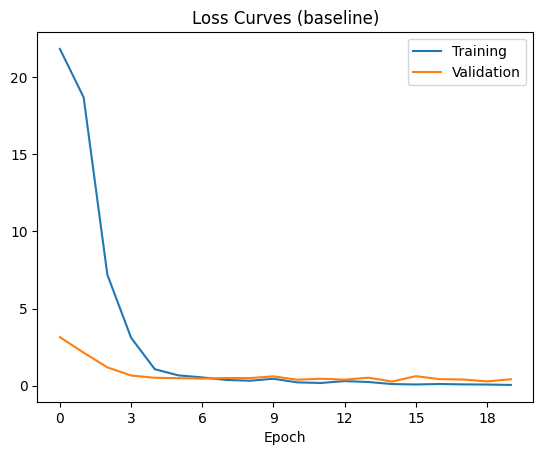

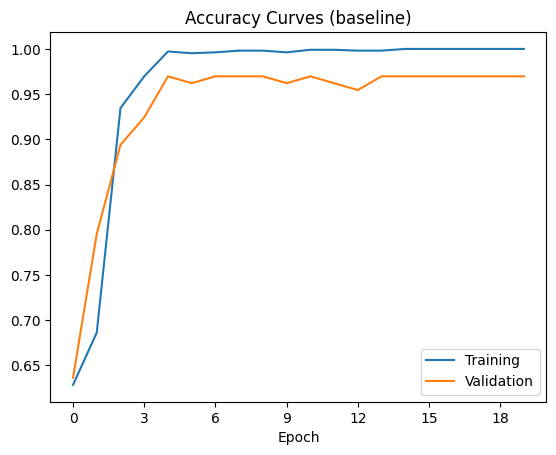

In [ ]:
# plot the results --------------------------------------------------------
plt.plot(train_loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.title("Loss Curves ("+SAVE_AS_ITER+")")
plt.xlabel("Epoch")
plt.xticks(range(0,EPOCHS,3))
plt.legend()
plt.figure()
plt.plot(train_acc, label='Training' )
plt.plot(val_acc, label='Validation')
plt.title("Accuracy Curves ("+SAVE_AS_ITER+")")
plt.xlabel("Epoch")
plt.xticks(range(0,EPOCHS,3))
plt.legend()

In [ ]:
# evaluate model with test dataset ----------------------------------------
_, test_acc = eval(model, device, test_dl)
print("Test Accuracy:", test_acc)

Test Accuracy: 0.9848484848484849


In [ ]:
# do manual review of subsets ---------------------------------------------
# _, sub_acc = subset_eval_with_print(model, device, test_ds, subset_len=10)
# print("Subset Test Accuracy:", sub_acc)

# TODO: write functions to save plots and models